In [16]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [17]:
import torchvision.utils as utils

In [4]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

In [26]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
if is_gpu:
    fixed_z_ = Variable(fixed_z_.cuda(), volatile=True)# for inference only and no back-prop(doesn't save the states)
else :
    fixed_z_ = Variable(fixed_z_, volatile=True)
def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
    if is_gpu:
        z_ = Variable(z_.cuda(), volatile=True)
    else :
        z_ = Variable(z_, volatile=True)

        

    G.eval()
    if isFix:
        test_images = G(fixed_z_)
    else:
        test_images = G(z_)
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


In [20]:
batch_size = 128
lr = 0.0002
train_epoch = 20

# data_loader
img_size = 64
transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./datasets/', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

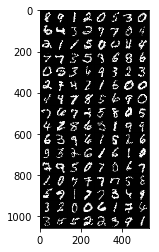

In [22]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
# print("Train images", train_images)
# print("Train images", train_labels)
imshow(utils.make_grid(train_images))


In [25]:
is_gpu = torch.cuda.is_available()

In [27]:
# network
G = generator(128)
D = discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
if is_gpu:
    G.cuda()
    D.cuda()

In [29]:
# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
if not os.path.isdir('MNIST_DCGAN_results'):
    os.mkdir('MNIST_DCGAN_results')
if not os.path.isdir('MNIST_DCGAN_results/Random_results'):
    os.mkdir('MNIST_DCGAN_results/Random_results')
if not os.path.isdir('MNIST_DCGAN_results/Fixed_results'):
    os.mkdir('MNIST_DCGAN_results/Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
num_iter = 0

print('training start!')

training start!


In [30]:
start_time = time.time()
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for x_, _ in train_loader:
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        if is_gpu:
            x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        else:
            x_, y_real_, y_fake_ = Variable(x_), Variable(y_real_), Variable(y_fake_)

        D_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        if is_gpu:
            z_ = Variable(z_.cuda())
        else:
            z_ = Variable(z_)
        G_result = G(z_)

        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        # D_losses.append(D_train_loss.data[0])
        D_losses.append(D_train_loss.data[0])

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)#heuristic loss by using y_real imposes maximization
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.data[0])

        num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time


    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    p = 'MNIST_DCGAN_results/Random_results/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    fixed_p = 'MNIST_DCGAN_results/Fixed_results/MNIST_DCGAN_' + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=p, isFix=False)
    show_result((epoch+1), save=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)


[1/20] - ptime: 340.05, loss_d: 0.607, loss_g: 7.621
[2/20] - ptime: 338.06, loss_d: 0.684, loss_g: 2.310
[3/20] - ptime: 337.75, loss_d: 0.644, loss_g: 2.772
[4/20] - ptime: 336.60, loss_d: 0.604, loss_g: 3.081
[5/20] - ptime: 487.93, loss_d: 0.502, loss_g: 3.346
[6/20] - ptime: 460.74, loss_d: 0.546, loss_g: 3.229
[7/20] - ptime: 337.27, loss_d: 0.449, loss_g: 3.463
[8/20] - ptime: 337.28, loss_d: 0.564, loss_g: 3.235
[9/20] - ptime: 337.80, loss_d: 0.423, loss_g: 3.615
[10/20] - ptime: 337.34, loss_d: 0.467, loss_g: 3.440
[11/20] - ptime: 336.51, loss_d: 0.499, loss_g: 3.401
[12/20] - ptime: 336.85, loss_d: 0.400, loss_g: 3.636
[13/20] - ptime: 336.91, loss_d: 0.503, loss_g: 3.586
[14/20] - ptime: 336.61, loss_d: 0.432, loss_g: 3.623
[15/20] - ptime: 337.40, loss_d: 0.447, loss_g: 3.757
[16/20] - ptime: 337.00, loss_d: 0.188, loss_g: 4.526
[17/20] - ptime: 337.07, loss_d: 0.487, loss_g: 3.676
[18/20] - ptime: 337.28, loss_d: 0.408, loss_g: 3.758
[19/20] - ptime: 336.59, loss_d: 0.30

In [31]:

print("Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), "MNIST_DCGAN_results/generator_param.pkl")
torch.save(D.state_dict(), "MNIST_DCGAN_results/discriminator_param.pkl")
with open('MNIST_DCGAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path='MNIST_DCGAN_results/MNIST_DCGAN_train_hist.png')

images = []
for e in range(train_epoch):
    img_name = 'MNIST_DCGAN_results/Fixed_results/MNIST_DCGAN_' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('MNIST_DCGAN_results/generation_animation.gif', images, fps=5)

Avg per epoch ptime: 351.02, total 20 epochs ptime: 7234.01
Training finish!... save training results


In [33]:
i = imageio.mimread('MNIST_DCGAN_results/generation_animation.gif')

In [37]:
from IPython.display import Image as gif_view
gif_view(url="MNIST_DCGAN_results/generation_animation.gif")


In [32]:
images = []
for e in range(8):
    img_name = 'MNISTM_DCGAN_results/Fixed_results/MNISTM_DCGAN_' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
    print e
imageio.mimsave('MNISTM_DCGAN_results/generation_animation2.gif', images, fps=1)

0
1
2
3
4
5
6
7


In [33]:
from IPython.display import Image as gif_view
gif_view(url="MNISTM_DCGAN_results/generation_animation2.gif")


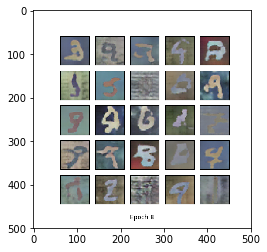

In [35]:
from PIL import Image
plt.imshow(Image.open("MNISTM_DCGAN_results/Fixed_results/MNISTM_DCGAN_8.png"))
plt.show()